# Natural Splines

In [1]:
import numpy as np
from numpy.typing import NDArray

from plotly import graph_objects as go


# define d method in splines
def d_k(
    k: int, x: NDArray[np.float64], knots: NDArray[np.float64]
) -> NDArray[np.float64]:
    return (((x - knots[k - 1]) ** 3).clip(0) - ((x - knots[-1]) ** 3).clip(0)) / (
        knots[-1] - knots[k - 1]
    )


def N_k(
    k: int, x: NDArray[np.float64], knots: NDArray[np.float64]
) -> NDArray[np.float64]:
    K = len(knots)
    if k == 1:
        return np.ones_like(x)
    if k == 2:
        return x
    k -= 2
    return d_k(k, x, knots) - d_k(K - 1, x, knots)

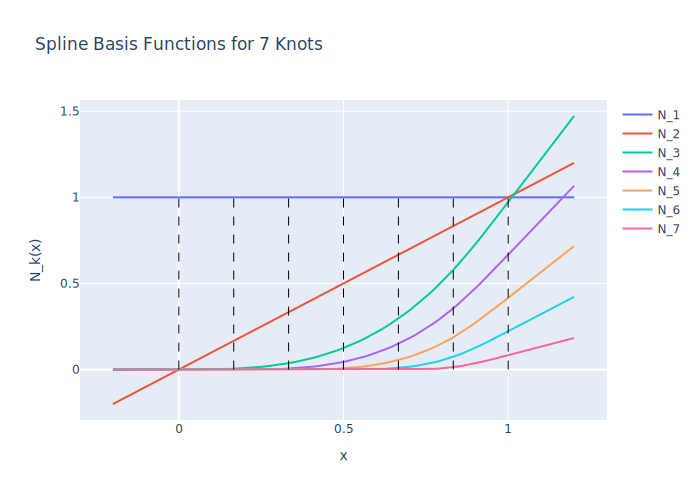

In [2]:
## let's plot the basis functions for K knots
def plot_basis_functions(K: int) -> go.Figure:
    knots = np.linspace(0, 1, K)
    plot_min, plot_max = -0.2, 1.2
    xs = np.linspace(plot_min, plot_max, 100)
    basis_evaluations = [N_k(k, xs, knots) for k in range(1, K + 1)]
    basis_figure = go.Figure()
    # add dotted lines at the knots
    for knot in knots:
        basis_figure.add_shape(
            dict(
                type="line",
                x0=knot,
                y0=0,
                x1=knot,
                y1=1,
                line=dict(color="black", width=1, dash="dash"),
            )
        )
    for k, basis in enumerate(basis_evaluations):
        basis_figure.add_trace(go.Scatter(x=xs, y=basis, mode="lines", name=f"N_{k+1}"))
    buffer = 0.1
    basis_figure.update_layout(
        title=f"Spline Basis Functions for {K} Knots",
        xaxis_title="x",
        yaxis_title="N_k(x)",
    )
    basis_figure.update_xaxes(range=[plot_min - buffer, plot_max + buffer])
    return basis_figure


basis_fig = plot_basis_functions(K=7)
basis_fig.show("svg")

### Let's fit a splines to the data

In [3]:
from itertools import product


def get_basis_evaluations(
    x: NDArray[np.float64], knots: NDArray[np.float64]
) -> NDArray[np.float64]:
    """Evaluate the basis functions at the points x for the given knots."""
    K = len(knots)
    return np.column_stack([N_k(k, x, knots) for k in range(1, K + 1)])


def o_i_j(i: int, j: int, knots: NDArray[np.float64]) -> NDArray[np.float64]:
    """Calculate the value of the Omega matrix of second derivatives"""
    if i <= 1 or j <= 1:
        return np.array(0)
    if i > j:  # ensure i < j for formula to work
        i, j = j, i
    return (
        -18 * knots[i - 2] * knots[j - 2] ** 2
        + 24 * knots[i - 2] * knots[j - 2] * knots[-2]
        + 12 * knots[i - 2] * knots[j - 2] * knots[-1]
        - 6 * knots[i - 2] * knots[-2] ** 2
        - 12 * knots[i - 2] * knots[-1] * knots[-2]
        + 6 * knots[j - 2] ** 3
        - 6 * knots[j - 2] * knots[-2] ** 2
        - 12 * knots[j - 2] * knots[-1] * knots[-2]
        + 12 * knots[-2] ** 2 * knots[-1]
    ) / ((knots[-1] - knots[i - 2]) * (knots[-1] - knots[j - 2]))


def get_sigma_n(knots: NDArray[np.float64]) -> NDArray[np.float64]:
    K = len(knots)
    O = np.zeros((K, K))
    for i, j in product(range(K), range(K)):
        O[i, j] = o_i_j(i, j, knots)
    return O

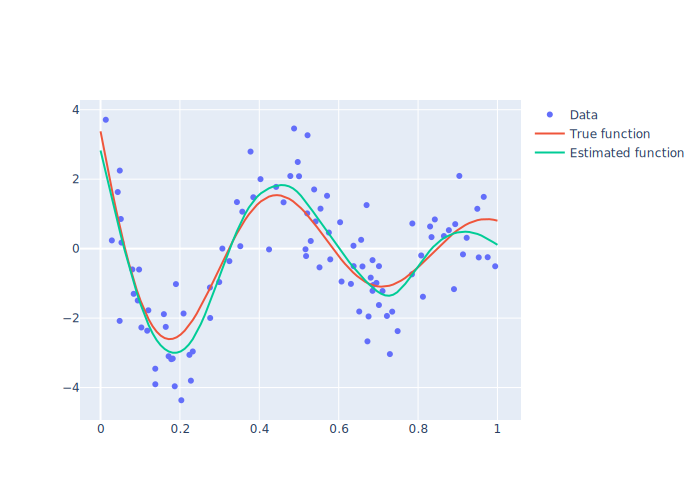

In [8]:
def example_splines_fit() -> go.Figure:
    """Fit a spline to some noisy data."""

    np.random.seed(101)

    # Define the model y and x as 100 uniform points between 0 and 1
    x = np.random.uniform(0, 1, 100)
    plot_x = np.linspace(0, 1, 100)

    def f(x: NDArray[np.float64]) -> NDArray[np.float64]:
        return np.sin(12 * (x + 0.2)) / (x + 0.2)

    epsilon = np.random.normal(0, 1, 100)
    E_y = f(x)
    y = E_y + epsilon

    # fit the splines
    knots = np.unique(x)
    N = get_basis_evaluations(x, knots)
    n, K = N.shape
    O = get_sigma_n(knots)
    theta = np.linalg.inv(N.T @ N + 0.00022 * O) @ N.T @ y
    evaluation = get_basis_evaluations(plot_x, knots) @ theta

    # Use plotly to plot the data and the true function
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="Data"))
    fig.add_trace(go.Scatter(x=plot_x, y=f(plot_x), mode="lines", name="True function"))
    fig.add_trace(
        go.Scatter(x=plot_x, y=evaluation, mode="lines", name="Estimated function")
    )

    # plot the evaluation
    return fig


example_splines_fig = example_splines_fit()
example_splines_fig.show("svg")